In [1]:
from pyaudi import gdual_double, gdual_vdouble
import pyaudi as pa 
import numpy as np
# import chaospy as cp 
import seaborn
# seaborn.set_style('whitegrid')
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
print(plt.style.available)
plt.style.use("seaborn-whitegrid")

from Utils.boxgrid import boxgrid
import Utils.DA as da
from Utils.RK4 import RK4
from Utils.autograd_adjoint import odeint 

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', '_classic_test']


# Goal
Compare forward sensitivity using DA+RK4 implementation with adjoint sensitivity, demostrating that they indeed produce the same information. 

In [2]:
np.shape([[1, 0, 0],[1, 1, 1]])

(2, 3)

In [3]:
# Problem Data 
def dynamics(x, t, a):
    dx = np.zeros_like(x, dtype=type(a))
    dx[0] = x[1]
    dx[1] = -a*x[1]**2 + pa.sin(0.1*t)
    return dx 

def jacobian(x, a):
    return np.array([[0, 1, 0],[0, -2*a*x[1], -x[1]**2],[0,0,0]])

tf = 3
t = np.linspace(0, tf, 30)

x0 = [1, 3.5] 
a = 0.2




Differential algebra solution

In [7]:
A = gdual_double(a, 'a', 2)
X0 = da.make(x0, ['x1','x2'], 2)

X = RK4(dynamics, X0, t, args=(A,))
names = ['x1','x2','a']
gradient = da.jacobian(X[-1], names)
stm = [da.jacobian(x, names) for x in X] # change in [x1, x2] wrt [x10, x20, a]
# hessian = [da.hessian(x, names) for x in X[-1]]
print(gradient)

[[  1.           0.95422178 -11.60632431]
 [  0.           0.09259175  -4.06126647]]


Adjoint solution

[[  1.           0.95377046 -11.61434912]
 [  0.           0.09251384  -4.06271339]]


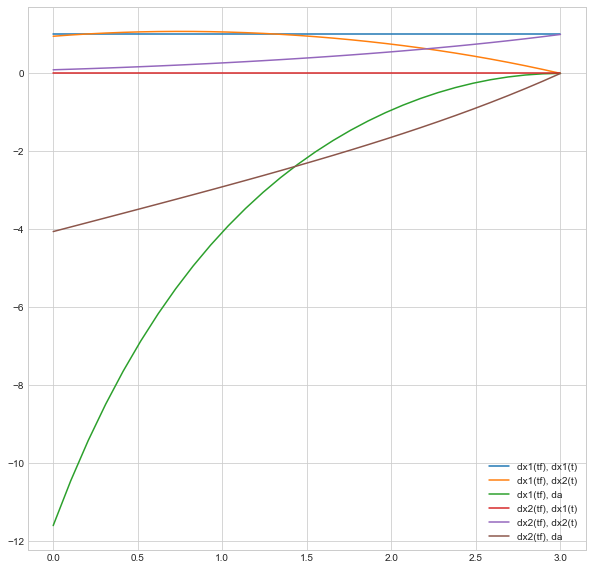

In [16]:
from scipy.interpolate import interp1d 

x = da.const(X, array=True)
x_interp = interp1d(t, x, axis=0, bounds_error=False, fill_value=(x[0],x[-1]))

def adjoint_dyn(p, t, X, J,):
    x = X(t)
    A = J(x)
    dp = -A.T.dot(p)
    return dp

J0 = []
P0 = np.eye(3)[:2]
plt.figure(figsize=(10,10))
for p0 in P0:
    Y = odeint(adjoint_dyn, p0, t[::-1], args=(x_interp, lambda x: jacobian(x,a),))
    plt.plot(t, Y[::-1])
    J0.append(Y[-1])
J0 = np.array(J0)
print(J0)
plt.legend(["dx1(tf), dx1(t)", "dx1(tf), dx2(t)", "dx1(tf), da","dx2(tf), dx1(t)", "dx2(tf), dx2(t)", "dx2(tf), da"])
plt.show()

In [6]:
assert np.allclose(gradient, J0, rtol=1e-1, atol=1e-2), "Forward and Adjoint Sensitivities do not match!"
print(np.max(np.abs(gradient-J0)))

0.008024818135073275


Determine the control costate with respect to the first state, i.e. $J = x_1$

(30, 2, 3)


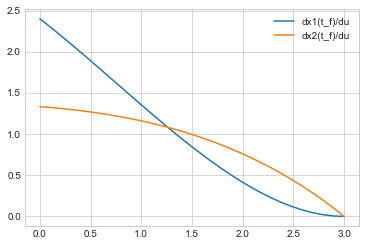

In [64]:
from scipy.integrate import cumtrapz
# This recovers the costates from STM 
dJdx = [[1, 0, 0],[0,1,0]]
stmi = [np.linalg.inv(np.append(st, [0,0,1]).reshape((3,3))) for st in stm]
stmf = np.append(stm[-1], [0,0,1]).reshape((3,3))
C = np.dot(dJdx, stmf)
p1 = np.array([np.dot(C, si) for si in stmi])
# plt.plot(t, p1[:,0])
# plt.plot(t, p1[:,1])

# p1 = [dx1/dx; dx2/dx]
print(p1.shape)
dfdu = [0, 1, 0]
# pu1 =  dx1(t_f)/du
pu1 = [np.trapz(x=t[i:], y=p1[i:,0,1]) for i in range(t.size)]  # Guaranteed to be correct
pu1_= -cumtrapz(x=t[::-1], y=np.squeeze(p1[::-1,0,1]), initial=0)[::-1] # so many weird flips required 
# Since integration is from tf to t, time and costate need to be reversed. Then, to plot against t, it must be reversed
# The negative sign is because pu1 is integrating forward, while pu1_ is integrating backward 
pu2 = [np.trapz(x=t[i:], y=p1[i:,1,1]) for i in range(t.size)]
plt.figure()
plt.plot(t, pu1, label="dx1(t_f)/du")
plt.plot(t, pu2, label="dx2(t_f)/du")
# plt.plot(t, pu1[0] - cumtrapz(x=t, y=pu2, initial=0))
plt.legend()
# plt.plot(t, pu1_,'o')
